In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
df = pd.read_csv(
    "/content/drive/MyDrive/ML_PROJECT_DATA/Resume Classifier/Resume.csv"
)


In [5]:
df.head()
df.shape
df.columns


Index(['Category', 'Resume'], dtype='object')

In [6]:
df.info()
df['Category'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


,count
Category,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Sales,40
Data Science,40


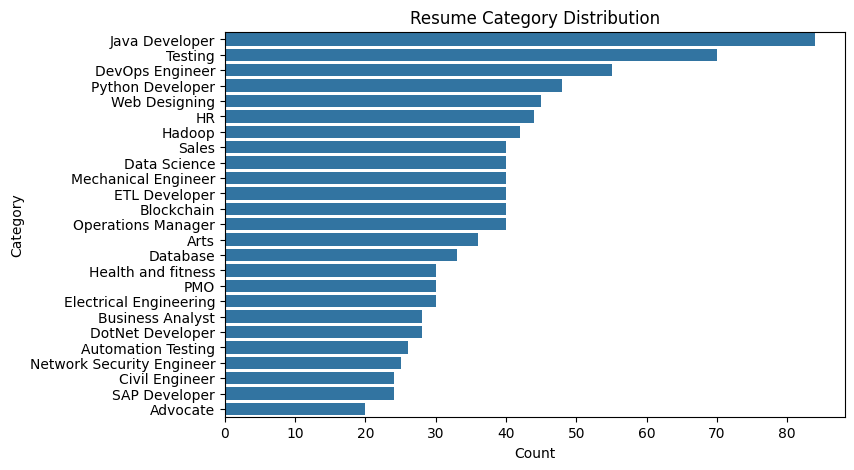

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(
    y=df['Category'],
    order=df['Category'].value_counts().index
)
plt.title("Resume Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    tokens = text.split()
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    return " ".join(tokens)


In [9]:
df['clean_resume'] = df['Resume'].apply(clean_text)


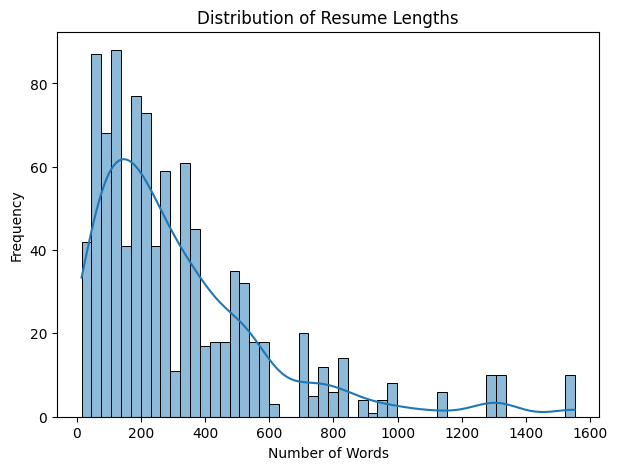

In [10]:
df['resume_length'] = df['clean_resume'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,5))
sns.histplot(df['resume_length'], bins=50, kde=True)
plt.title("Distribution of Resume Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [11]:
X = df['clean_resume']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', MultinomialNB())
])


In [13]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])


In [14]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1,2))),
    ('clf', LinearSVC())
])


In [15]:
pipelines = {
    "Naive Bayes": nb_pipeline,
    "Logistic Regression": lr_pipeline,
    "Linear SVM": svm_pipeline
}

results = []

for name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))



Model: Naive Bayes
Accuracy: 0.9481865284974094
                           precision    recall  f1-score   support

                 Advocate       1.00      0.50      0.67         4
                     Arts       0.88      1.00      0.93         7
       Automation Testing       1.00      0.60      0.75         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      0.88      0.93         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      0.20      0.33         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
            

In [18]:
from sklearn.metrics import accuracy_score

for name, model in pipelines.items():
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(f"\n{name}")
    print("Train accuracy:", accuracy_score(y_train, train_pred))
    print("Test accuracy:", accuracy_score(y_test, test_pred))



Naive Bayes
Train accuracy: 0.9713914174252276
Test accuracy: 0.9481865284974094

Logistic Regression
Train accuracy: 0.9986996098829649
Test accuracy: 0.9896373056994818

Linear SVM
Train accuracy: 1.0
Test accuracy: 0.9948186528497409


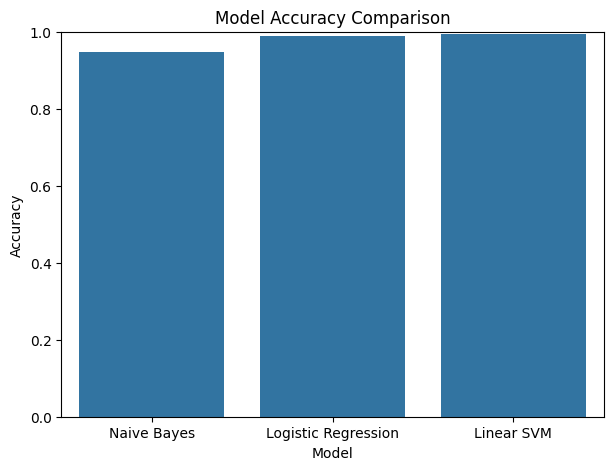

In [16]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])

plt.figure(figsize=(7,5))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


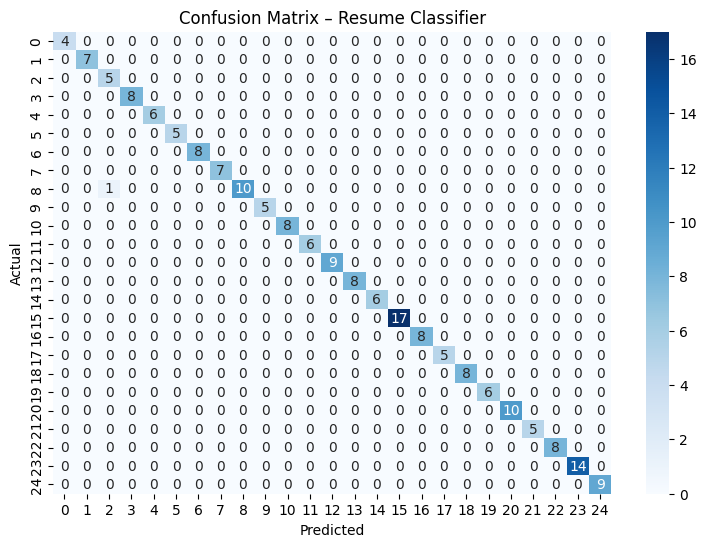

In [17]:
y_pred = svm_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Resume Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


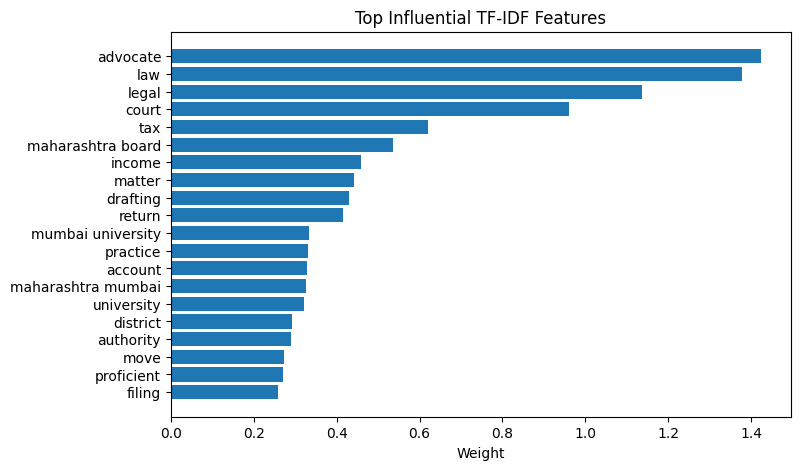

In [19]:
tfidf = svm_pipeline.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

coef = svm_pipeline.named_steps['clf'].coef_
top_indices = np.argsort(coef[0])[-20:]

plt.figure(figsize=(8,5))
plt.barh(
    [feature_names[i] for i in top_indices],
    coef[0][top_indices]
)
plt.title("Top Influential TF-IDF Features")
plt.xlabel("Weight")
plt.show()


In [20]:
joblib.dump(svm_pipeline, "resume_classifier_model.pkl")


['resume_classifier_model.pkl']

In [22]:
# 🔹 DEMO: PREDICTING DIFFERENT RESUME TYPES

In [27]:
resume_1 = """
Experienced Java developer with strong knowledge of Spring Boot, Hibernate,
REST APIs, MySQL, and microservices architecture.
"""

resume_2 = """
Data scientist with expertise in Python, pandas, numpy, machine learning,
data visualization, scikit-learn, and predictive modeling.
"""

resume_3 = """
Manual and automation testing engineer with experience in Selenium, TestNG,
JIRA, test case creation, regression testing, and bug tracking.
"""

resume_4 = """
DevOps engineer skilled in AWS, Docker, Kubernetes, CI/CD pipelines,
Linux, Jenkins, Terraform, and cloud infrastructure automation.
"""

resume_5 = """
Frontend developer with expertise in React, JavaScript, HTML, CSS, Redux,
UI/UX design, responsive web development, and performance optimization.
"""

resume_6 = """
Software engineer with experience in Python, Java, SQL, machine learning,
AWS, Docker, REST APIs, and React.
"""

resume_7 = """
I love building things. I have worked with data, computers, cloud platforms,
and various programming languages to solve problems.
"""


In [28]:
demo_resumes = {
    "Java Dev": resume_1,
    "Data Scientist": resume_2,
    "Tester": resume_3,
    "DevOps": resume_4,
    "Frontend": resume_5,
    "Mixed": resume_6,
    "Vague": resume_7
}

for name, text in demo_resumes.items():
    print(f"{name} → {svm_pipeline.predict([text])[0]}")


Java Dev → Java Developer
Data Scientist → Data Science
Tester → Automation Testing
DevOps → DevOps Engineer
Frontend → Web Designing
Mixed → Data Science
Vague → Hadoop


In [24]:
resume_3 = """
Manual and automation testing engineer with experience in Selenium, TestNG,
JIRA, test case creation, regression testing, and bug tracking.
"""

print("Prediction:", svm_pipeline.predict([resume_3])[0])


Prediction: Automation Testing
